In [1]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
import json
import sys
sys.path.append("..")
import util    # helper functions

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Get relevant secrets and variables

print("Connecting to Hopsworks...")
hopsworks_key = os.getenv("HOPSWORKS_API_KEY") 
hopsworks_project_name = os.getenv("HOPSWORKS_PROJECT")
project = hopsworks.login(project=hopsworks_project_name, api_key_value=hopsworks_key) 
fs = project.get_feature_store()

with open("../city_config/vastra_gotaland.json") as f:
    city_config = json.load(f)

country = "Sweden"
SENSORS = city_config["sensors"]
FG_VERSIONS = city_config["fg_versions"]

feature_view = city_config["feature_view"]
feature_view_name = feature_view['name']
feature_view_version = feature_view['version']

Connecting to Hopsworks...
2025-11-14 13:05:20,449 INFO: Initializing external client
2025-11-14 13:05:20,450 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-14 13:05:21,888 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1271989


In [3]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=FG_VERSIONS["air_quality"],
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=FG_VERSIONS["weather"],
)

forecast_fg = fs.get_feature_group(            # keeping forecast features separate
    name='weather_forecast_features',
    version=FG_VERSIONS["weather_forecast_features"],
)

In [ ]:
# --- Read all sensors' air quality ---
air_quality_df = air_quality_fg.read()

# Sort by date to ensure temporal order
air_quality_df = air_quality_df.sort_values(by=["city", "street", "date"])

# --- Create lag features for each sensor ---
for lag in [1, 2, 3]:
    air_quality_df[f"pm2_5_lag_{lag}"] = (
        air_quality_df
        .groupby(["city", "street"])["pm2_5"]
        .shift(lag)
    )

In [ ]:
lagged_fg = fs.get_or_create_feature_group(
    name="air_quality_lagged",
    description="Lagged air quality for all sensors",
    version=FG_VERSIONS["air_quality_lagged"],
    primary_key=["city", "street", "date"],
    event_time="date"
)

lagged_fg.insert(air_quality_df)

Uploading Dataframe: 100.00% |██████████| Rows 1853/1853 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: air_quality_lagged_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1271989/jobs/named/air_quality_lagged_1_offline_fg_materialization/executions


(Job('air_quality_lagged_1_offline_fg_materialization', 'SPARK'), None)

In [6]:
air_quality_df

,date,pm2_5,country,city,street,pm2_5_lag_1,pm2_5_lag_2,pm2_5_lag_3
1062,2019-11-06 00:00:00+00:00,15.0,Sweden,Göteborg,Femman,NaN,NaN,NaN
1747,2019-11-07 00:00:00+00:00,16.0,Sweden,Göteborg,Femman,15.0,NaN,NaN
95,2019-11-08 00:00:00+00:00,20.0,Sweden,Göteborg,Femman,16.0,15.0,NaN
1201,2019-11-09 00:00:00+00:00,14.0,Sweden,Göteborg,Femman,20.0,16.0,15.0
352,2019-11-10 00:00:00+00:00,14.0,Sweden,Göteborg,Femman,14.0,20.0,16.0
...,...,...,...,...,...,...,...,...
1850,2025-11-14 00:00:00+00:00,4.1,Sweden,Göteborg,Femman,2.3,7.0,34.0
1848,2025-11-15 00:00:00+00:00,3.9,Sweden,Göteborg,Femman,4.1,2.3,7.0
1847,2025-11-16 00:00:00+00:00,2.0,Sweden,Göteborg,Femman,3.9,4.1,2.3
1849,2025-11-17 00:00:00+00:00,2.5,Sweden,Göteborg,Femman,2.0,3.9,4.1


In [ ]:
# Select features for training data.
selected_features = lagged_fg.select(['pm2_5', 'pm2_5_lag_1', 'pm2_5_lag_2', 'pm2_5_lag_3', 'date', 'city', 'street']).join(weather_fg.select_features(), on=['city', 'street', 'date'])
# selected_features = air_quality_fg.select(['pm2_5', 'date']).join(weather_fg.select_features(), on=['city', 'street', 'date'])

2025-11-14 13:06:09,424 INFO: Using ['wind_speed_10m_max', 'wind_gusts_10m_max', 'wind_direction_10m_dominant', 'temperature_2m_max', 'country'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.


In [8]:
selected_features

In [9]:
feature_view = fs.get_or_create_feature_view(
    name=feature_view_name,
    description="Weather features with air quality (pm2.5) as the target",
    version=feature_view_version,
    labels=['pm2_5'],
    query=selected_features,
)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1271989/fs/1258587/fv/air_quality_fv/version/3


In [10]:
# Time-series split of train/test data
start_date_test_data = "2025-05-01"

# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [11]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.77s) 


In [12]:
X_train

,pm2_5_lag_1,pm2_5_lag_2,pm2_5_lag_3,date,city,street,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,temperature_2m_max,country
0,21.0,33.0,41.0,2020-01-10 00:00:00+00:00,Göteborg,Femman,21.2,40.3,35.0,3.5,Sweden
1,20.0,21.0,27.0,2020-01-24 00:00:00+00:00,Göteborg,Femman,26.7,51.5,256.0,7.2,Sweden
2,13.0,6.0,14.0,2020-02-01 00:00:00+00:00,Göteborg,Femman,27.7,54.0,221.0,7.6,Sweden
3,9.0,14.0,27.0,2020-02-26 00:00:00+00:00,Göteborg,Femman,22.1,45.0,32.0,1.7,Sweden
4,17.0,20.0,20.0,2020-03-02 00:00:00+00:00,Göteborg,Femman,22.6,44.6,186.0,6.8,Sweden
...,...,...,...,...,...,...,...,...,...,...,...
1839,25.0,48.0,57.0,2025-01-28 00:00:00+00:00,Göteborg,Femman,16.6,32.4,147.0,6.3,Sweden
1840,28.0,20.0,18.0,2025-02-18 00:00:00+00:00,Göteborg,Femman,11.7,27.4,312.0,3.2,Sweden
1841,40.0,47.0,55.0,2025-03-11 00:00:00+00:00,Göteborg,Femman,14.7,30.6,88.0,3.8,Sweden
1842,26.0,24.0,12.0,2025-03-16 00:00:00+00:00,Göteborg,Femman,27.1,59.8,352.0,6.7,Sweden


In [13]:
# Drop first few NaN rows from lagging from the train set (but not in test set to not shorten the eval period)
# valid_idx = X_train.dropna(subset=['pm2_5_lag_1', 'pm2_5_lag_2', 'pm2_5_lag_3']).index
# X_train = X_train.loc[valid_idx]
# y_train = y_train.loc[valid_idx]

In [14]:
X_train

,pm2_5_lag_1,pm2_5_lag_2,pm2_5_lag_3,date,city,street,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,temperature_2m_max,country
0,21.0,33.0,41.0,2020-01-10 00:00:00+00:00,Göteborg,Femman,21.2,40.3,35.0,3.5,Sweden
1,20.0,21.0,27.0,2020-01-24 00:00:00+00:00,Göteborg,Femman,26.7,51.5,256.0,7.2,Sweden
2,13.0,6.0,14.0,2020-02-01 00:00:00+00:00,Göteborg,Femman,27.7,54.0,221.0,7.6,Sweden
3,9.0,14.0,27.0,2020-02-26 00:00:00+00:00,Göteborg,Femman,22.1,45.0,32.0,1.7,Sweden
4,17.0,20.0,20.0,2020-03-02 00:00:00+00:00,Göteborg,Femman,22.6,44.6,186.0,6.8,Sweden
...,...,...,...,...,...,...,...,...,...,...,...
1839,25.0,48.0,57.0,2025-01-28 00:00:00+00:00,Göteborg,Femman,16.6,32.4,147.0,6.3,Sweden
1840,28.0,20.0,18.0,2025-02-18 00:00:00+00:00,Göteborg,Femman,11.7,27.4,312.0,3.2,Sweden
1841,40.0,47.0,55.0,2025-03-11 00:00:00+00:00,Göteborg,Femman,14.7,30.6,88.0,3.8,Sweden
1842,26.0,24.0,12.0,2025-03-16 00:00:00+00:00,Göteborg,Femman,27.1,59.8,352.0,6.7,Sweden


In [ ]:
lag_cols = ['pm2_5_lag_1', 'pm2_5_lag_2', 'pm2_5_lag_3']
# Forward-fill missing lag values
X_train[lag_cols] = X_train.groupby(['city','street'])[lag_cols].ffill().bfill()
X_test[lag_cols] = X_test.groupby(["city", "street"])[lag_cols].ffill().bfill()

In [20]:
X_features = X_train.drop(columns=['date','country', 'city', 'street'])
X_test_features = X_test.drop(columns=['date', 'country', 'city', 'street'])

In [21]:
X_features

,pm2_5_lag_1,pm2_5_lag_2,pm2_5_lag_3,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,temperature_2m_max
0,21.0,33.0,41.0,21.2,40.3,35.0,3.5
1,20.0,21.0,27.0,26.7,51.5,256.0,7.2
2,13.0,6.0,14.0,27.7,54.0,221.0,7.6
3,9.0,14.0,27.0,22.1,45.0,32.0,1.7
4,17.0,20.0,20.0,22.6,44.6,186.0,6.8
...,...,...,...,...,...,...,...
1839,25.0,48.0,57.0,16.6,32.4,147.0,6.3
1840,28.0,20.0,18.0,11.7,27.4,312.0,3.2
1841,40.0,47.0,55.0,14.7,30.6,88.0,3.8
1842,26.0,24.0,12.0,27.1,59.8,352.0,6.7


In [22]:
y_train

,pm2_5
0,9.0
1,19.0
2,23.0
3,7.0
4,24.0
...,...
1839,32.0
1840,41.0
1841,14.0
1842,19.0


In [23]:
# Hyperparameter tuning:
# Define the hyperparameter grid
param_dist = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.1, 0.05, 0.01],
    'subsample': [0.6, 0.8, 1],
    'colsample_bytree': [0.6, 0.8, 1],
    'n_estimators': [100, 300, 500],
    'gamma': [0, 1, 5]
}

# Create the XGBoost model object
xgb_model = XGBRegressor()

random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=50,        # number of random combinations
    cv=5,
    scoring='neg_mean_squared_error',  # regression metric
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_features, y_train)

best_params = random_search.best_params_ 
print("Best hyperparameters:", best_params)
print("Best MSE:", -random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=1, gamma=1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1; total time=   0.1s
[CV] END colsample_bytree=1, gamma=1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1; total time=   0.1s
[CV] END colsample_bytree=1, gamma=1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1; total time=   0.2s
[CV] END colsample_bytree=1, gamma=1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1; total time=   0.2s
[CV] END colsample_bytree=1, gamma=1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1; total time=   0.1s
[CV] END colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.6; total time=   0.6s
[CV] END colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.6; total time=   0.6s
[CV] END colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=10, n_estimators=100, 

In [24]:
# Modelling

# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor(**best_params, random_state=42)

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [25]:
# Forward-fill NaNs using previous day's value
X_test = X_test.fillna(method='ffill')

In [26]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 83.11231541837205
R squared: 0.3500429596943453


In [27]:
df = y_test
df['predicted_pm25'] = y_pred

In [28]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.head(5)

,pm2_5,predicted_pm25,date
1041,54.0,34.436455,2025-05-01 00:00:00+00:00
695,47.0,40.431755,2025-05-02 00:00:00+00:00
823,24.0,30.382965,2025-05-03 00:00:00+00:00
343,9.0,18.436916,2025-05-04 00:00:00+00:00
1379,20.0,16.721054,2025-05-05 00:00:00+00:00


In [29]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "../air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

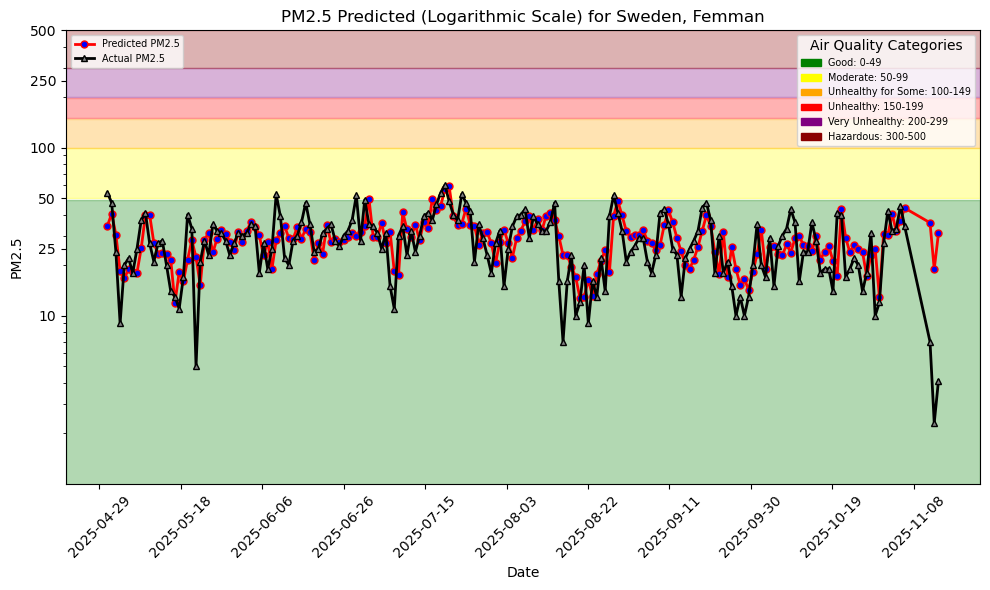

In [30]:
file_path = images_dir + "/pm25_hindcast.png"
plt = util.plot_air_quality_forecast(city, street, df, file_path, hindcast=True) 
plt.show()

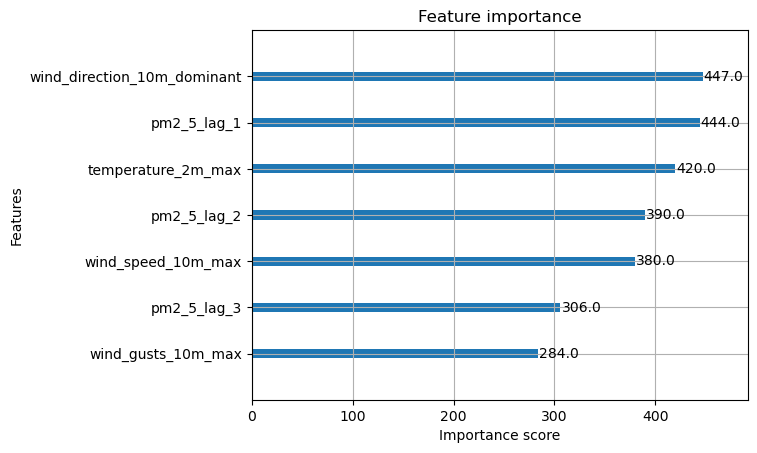

In [31]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

In [32]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model.json")

In [33]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [34]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="air_quality_xgboost_model_with_lag_features_2", 
    metrics= res_dict,
    feature_view=feature_view,
    description="Air Quality (PM2.5) predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/kajsalidin/Desktop/ID2223_air_quality_prediction/pipelines/../air_quality_model/model.json: 0…

Uploading /Users/kajsalidin/Desktop/ID2223_air_quality_prediction/pipelines/../air_quality_model/images/featur…

Uploading /Users/kajsalidin/Desktop/ID2223_air_quality_prediction/pipelines/../air_quality_model/images/pm25_f…

Uploading /Users/kajsalidin/Desktop/ID2223_air_quality_prediction/pipelines/../air_quality_model/images/pm25_h…

Uploading /Users/kajsalidin/Desktop/ID2223_air_quality_prediction/pipelines/../air_quality_model/images/pm25_h…

Uploading /Users/kajsalidin/Desktop/ID2223_air_quality_prediction/pipelines/../air_quality_model/daily_plots/f…

Uploading /Users/kajsalidin/Desktop/ID2223_air_quality_prediction/pipelines/../air_quality_model/daily_plots/h…

Uploading /Users/kajsalidin/Desktop/ID2223_air_quality_prediction/pipelines/../air_quality_model/daily_plots/f…

Uploading /Users/kajsalidin/Desktop/ID2223_air_quality_prediction/pipelines/../air_quality_model/daily_plots/h…

Uploading /Users/kajsalidin/Desktop/ID2223_air_quality_prediction/pipelines/model_schema.json: 0.000%|        …

Model created, explore it at https://c.app.hopsworks.ai:443/p/1271989/models/air_quality_xgboost_model_with_lag_features_2/2


Model(name: 'air_quality_xgboost_model_with_lag_features_2', version: 2)